**¿Qué es una serie temporal?**

El objeto básico de la previsión es la serie temporal, que es un conjunto de observaciones registradas a lo largo del tiempo. En las aplicaciones de previsión, las observaciones suelen registrarse con una frecuencia regular, como diaria o mensual.

Veamos un ejemplo de datos para series temporales.

In [2]:
import pandas as pd

df = pd.read_csv('Modelos/book_sales.csv', index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Esta serie registra el número de ventas de libros de tapa dura en una tienda minorista durante 30 días. Observa que tenemos una única columna de observaciones Tapa dura con un índice temporal Fecha.

**Regresión lineal con series temporales**

En la primera parte de este curso, utilizaremos el algoritmo de regresión lineal para construir modelos de previsión. La regresión lineal se utiliza ampliamente en la práctica y se adapta con naturalidad incluso a tareas de previsión complejas.

*Time-step features(Funciones de paso del tiempo)*

Existen dos tipos de características propias de las series temporales: las características de paso temporal y las características de desfase.

Las características de paso temporal son las que podemos derivar directamente del índice temporal. La característica de paso temporal más básica es la variable ficticia de tiempo, que cuenta los pasos temporales de la serie desde el principio hasta el final.

Veamos un ejemplo.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('Modelos/book_sales.csv', index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Veamoslo de forma visual.

Text(0.5, 1.0, 'Time Plot of Hardcover Sales')

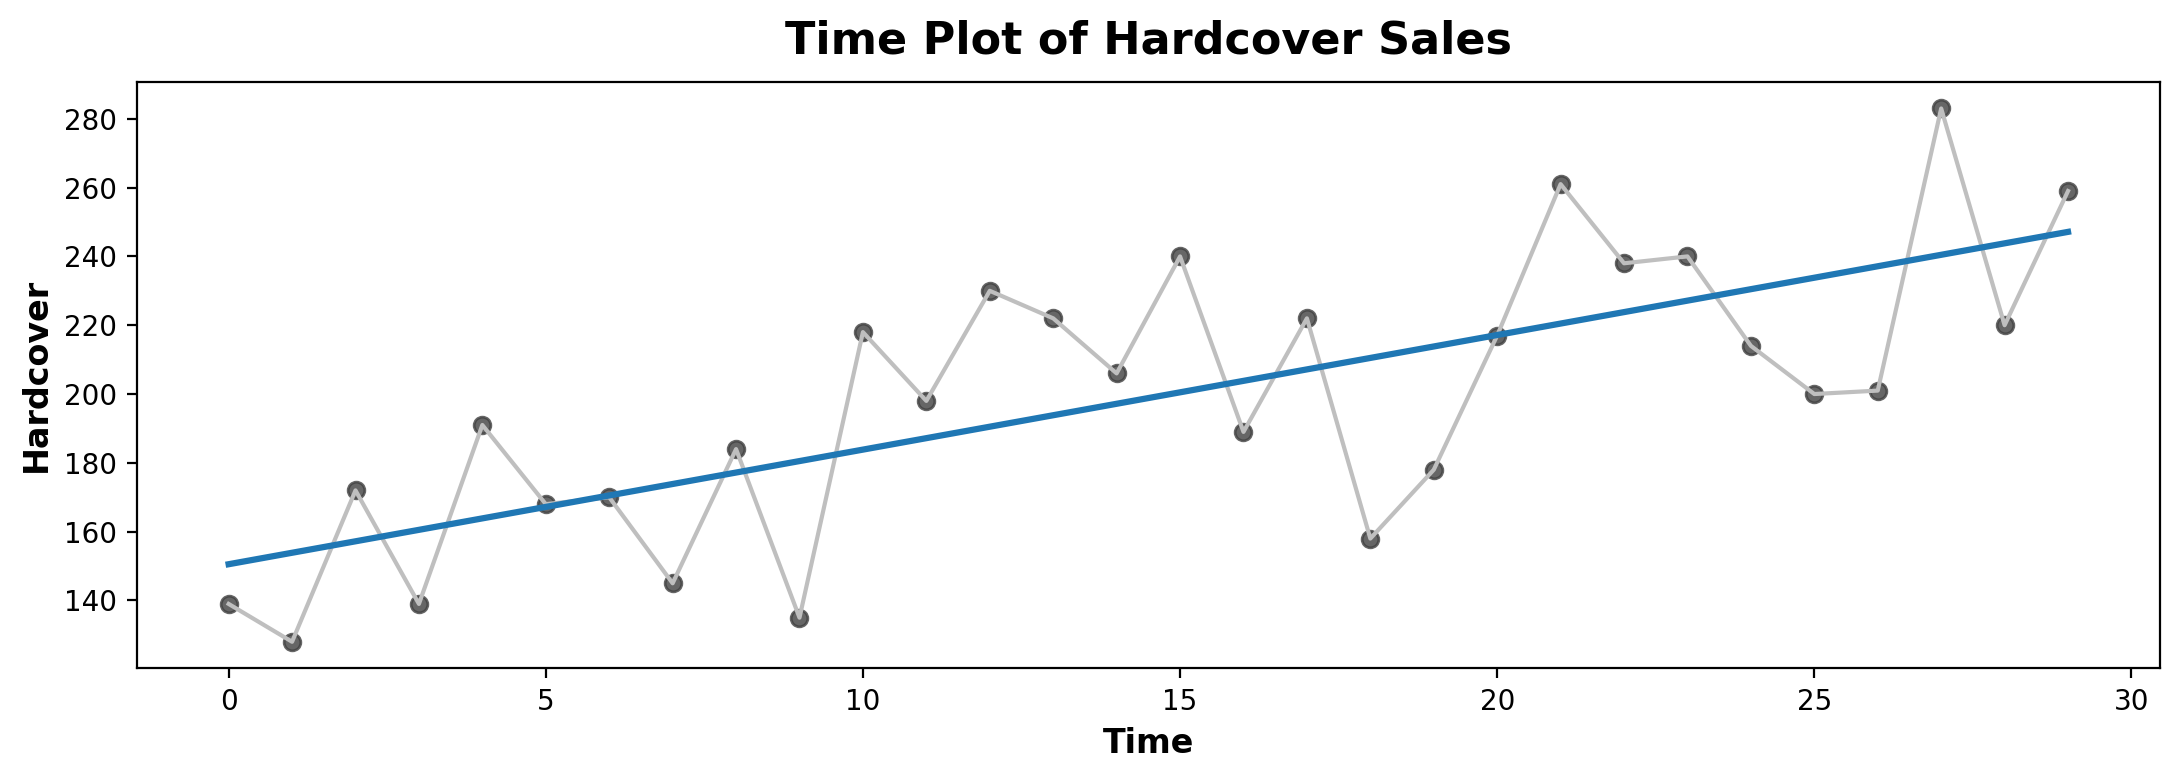

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_csv('Modelos/book_sales.csv', index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

df['Time'] = np.arange(len(df.index))

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales')

Las funciones de paso del tiempo permiten modelar la dependencia temporal. Una serie depende del tiempo si sus valores pueden predecirse a partir del momento en que se produjeron. En la serie de ventas de Hardcover, podemos predecir que las ventas de finales de mes suelen ser superiores a las de principios de mes.

*Lag features*

Para crear una característica de lag(desfase), desplazamos las observaciones de la serie objetivo de modo que parezca que se han producido más tarde en el tiempo. En este caso vamos a crear un desfase de 1 paso, aunque también es posible desplazarlo varios pasos.

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


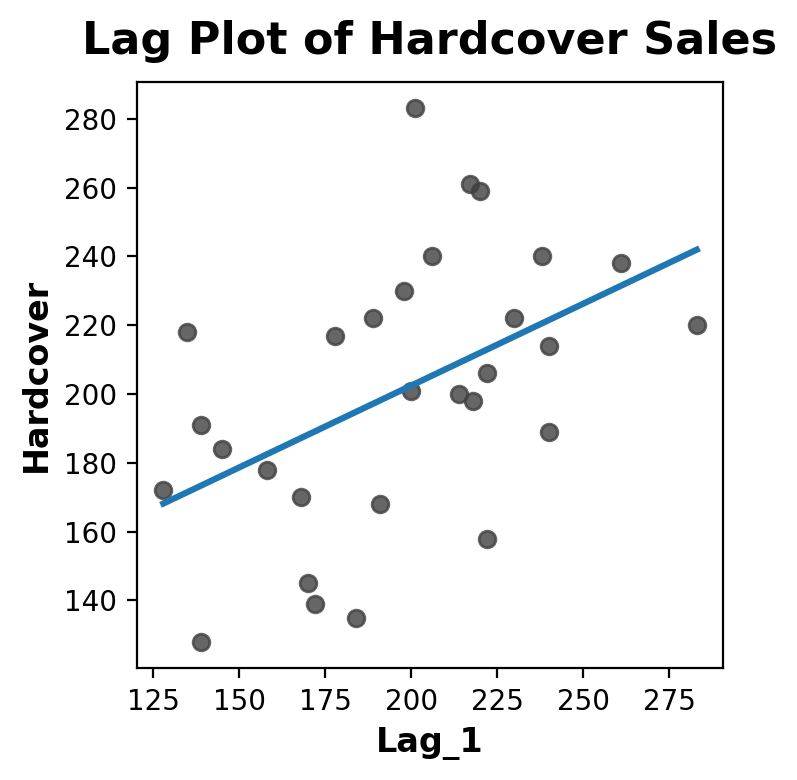

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('Modelos/book_sales.csv', index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

df['Time'] = np.arange(len(df.index))
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

df.head()

En el gráfico de desfase se puede ver que las ventas de un día (Hardcover) están correlacionadas con las ventas del día anterior (Lag_1). Cuando se observa una relación de este tipo, se sabe que una función de desfase será útil.

En términos más generales, las características de desfase permiten modelar la dependencia serial. Una serie temporal tiene dependencia serial cuando una observación puede predecirse a partir de observaciones anteriores. En Hardcover Sales, podemos predecir que las ventas elevadas de un día suelen significar ventas elevadas al día siguiente.

La adaptación de los algoritmos de aprendizaje automático a los problemas de series temporales consiste en gran medida en la ingeniería de características con el índice temporal y los retardos. Durante la mayor parte del curso, utilizaremos la regresión lineal por su sencillez, pero estas características serán útiles sea cual sea el algoritmo que elija para su tarea de previsión.

**Ejemplo - Túnel de tráfico**

Tráfico en el túnel es una serie temporal que describe el número de vehículos que atraviesan el túnel de Baregg (Suiza) cada día entre noviembre de 2003 y noviembre de 2005. En este ejemplo, obtendremos algo de práctica aplicando la regresión lineal a características de paso de tiempo y características de retardo.

La celda oculta establece todo.

In [18]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignorar las advertencias para limpiar las celdas de salida

plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

tunnel = pd.read_csv("Modelos/tunnel.csv", parse_dates=["Day"])

# Cree una serie temporal en Pandas estableciendo el índice en una columna de fecha. Parseamos "Day" como un tipo de fecha usando `parse_dates` al cargar los datos.
tunnel = tunnel.set_index("Day")

# Por defecto, Pandas crea un `DatetimeIndex` con dtype `Timestamp` 
# (equivalente a `np.datetime64`, representando una serie temporal como una secuencia de medidas tomadas en momentos puntuales. 
# Un `PeriodIndex`, por otro lado, representa una serie temporal como una secuencia de cantidades acumuladas a lo largo de periodos de tiempo. 
# Los períodos son a menudo más fáciles de trabajar, así que eso es lo que vamos a utilizar en este curso.
tunnel = tunnel.to_period()

# Siempre que no falte ninguna fecha en la serie temporal, podemos crear un ficticio de tiempo contando la longitud de la serie.

df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


El procedimiento para ajustar un modelo de regresión lineal sigue los pasos estándar de scikit-learn.

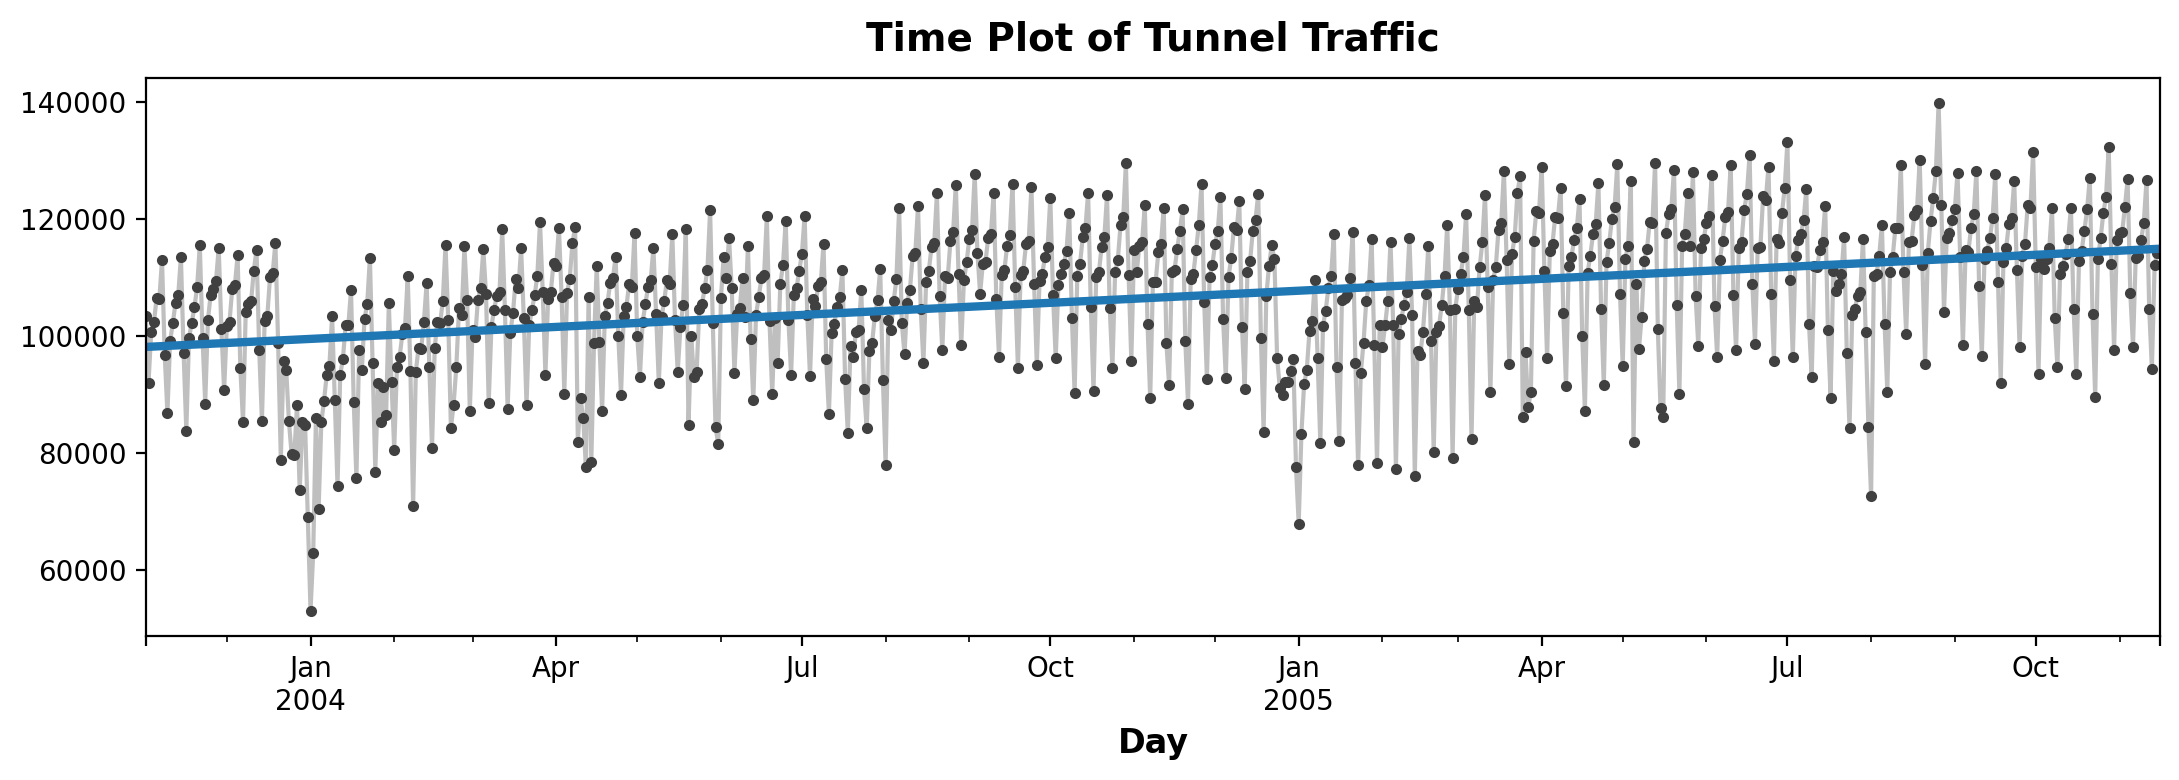

In [ ]:
from sklearn.linear_model import LinearRegression

# Datos de entrenamiento
X = df.loc[:, ['Time']]
y = df.loc[:, 'NumVehicles'] 

# Entrenar el modelo
model = LinearRegression()
model.fit(X, y)

# Almacenar los valores ajustados como una serie temporal con el mismo índice temporal que los datos de entrenamiento.
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic')

Probamos ahora a entrenar con lag.

Text(0.5, 1.0, 'Lag Plot of Tunnel Traffic')

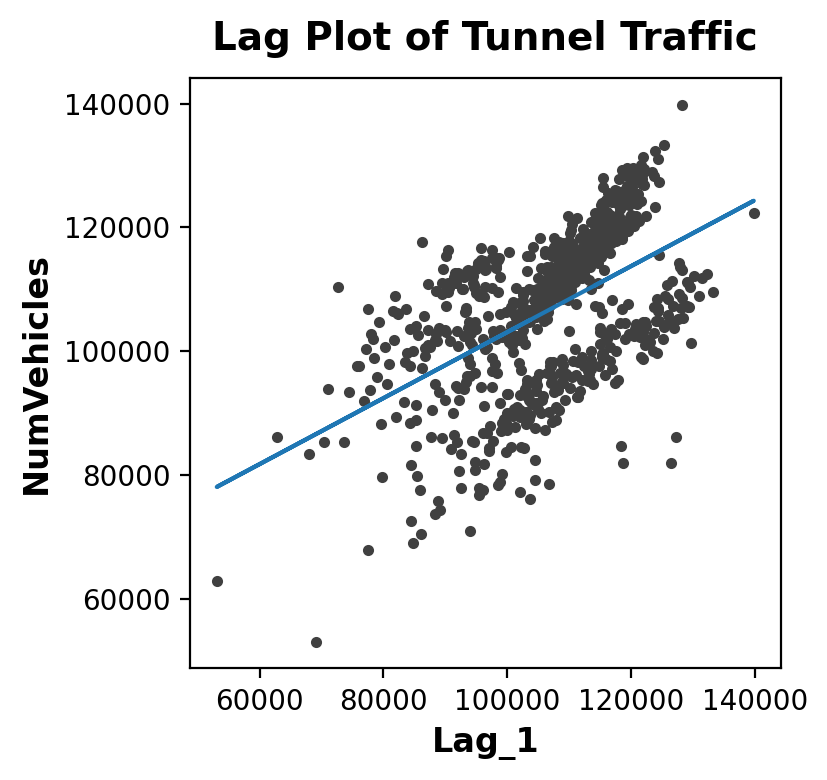

In [21]:
from sklearn.linear_model import LinearRegression

# Al crear características de desfase, tenemos que decidir qué hacer con 
# los valores que faltan. Una opción es rellenarlos con 0,0 o con el primer 
# valor conocido. En su lugar, simplemente eliminaremos los valores que faltan, 
# asegurándonos de eliminar también los valores en el objetivo de las fechas correspondientes.

df['Lag_1'] = df['NumVehicles'].shift(1)
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # eliminar los valores que faltan en el conjunto de características
y = df.loc[:, 'NumVehicles']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic')


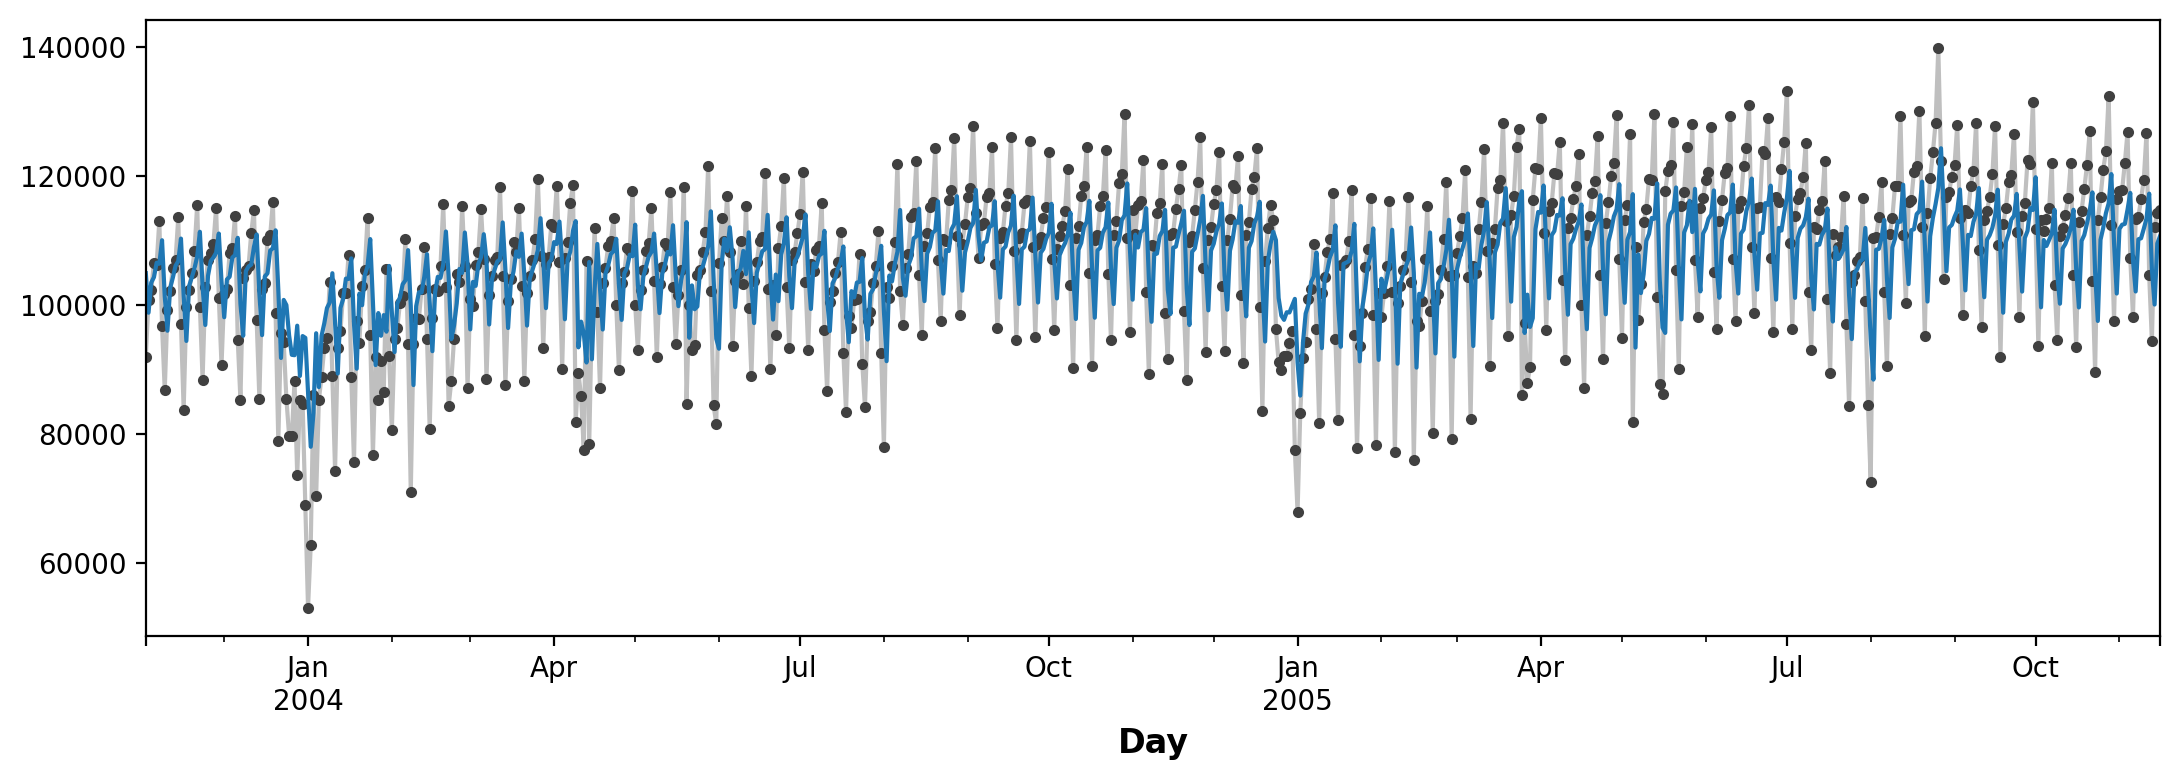

In [22]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

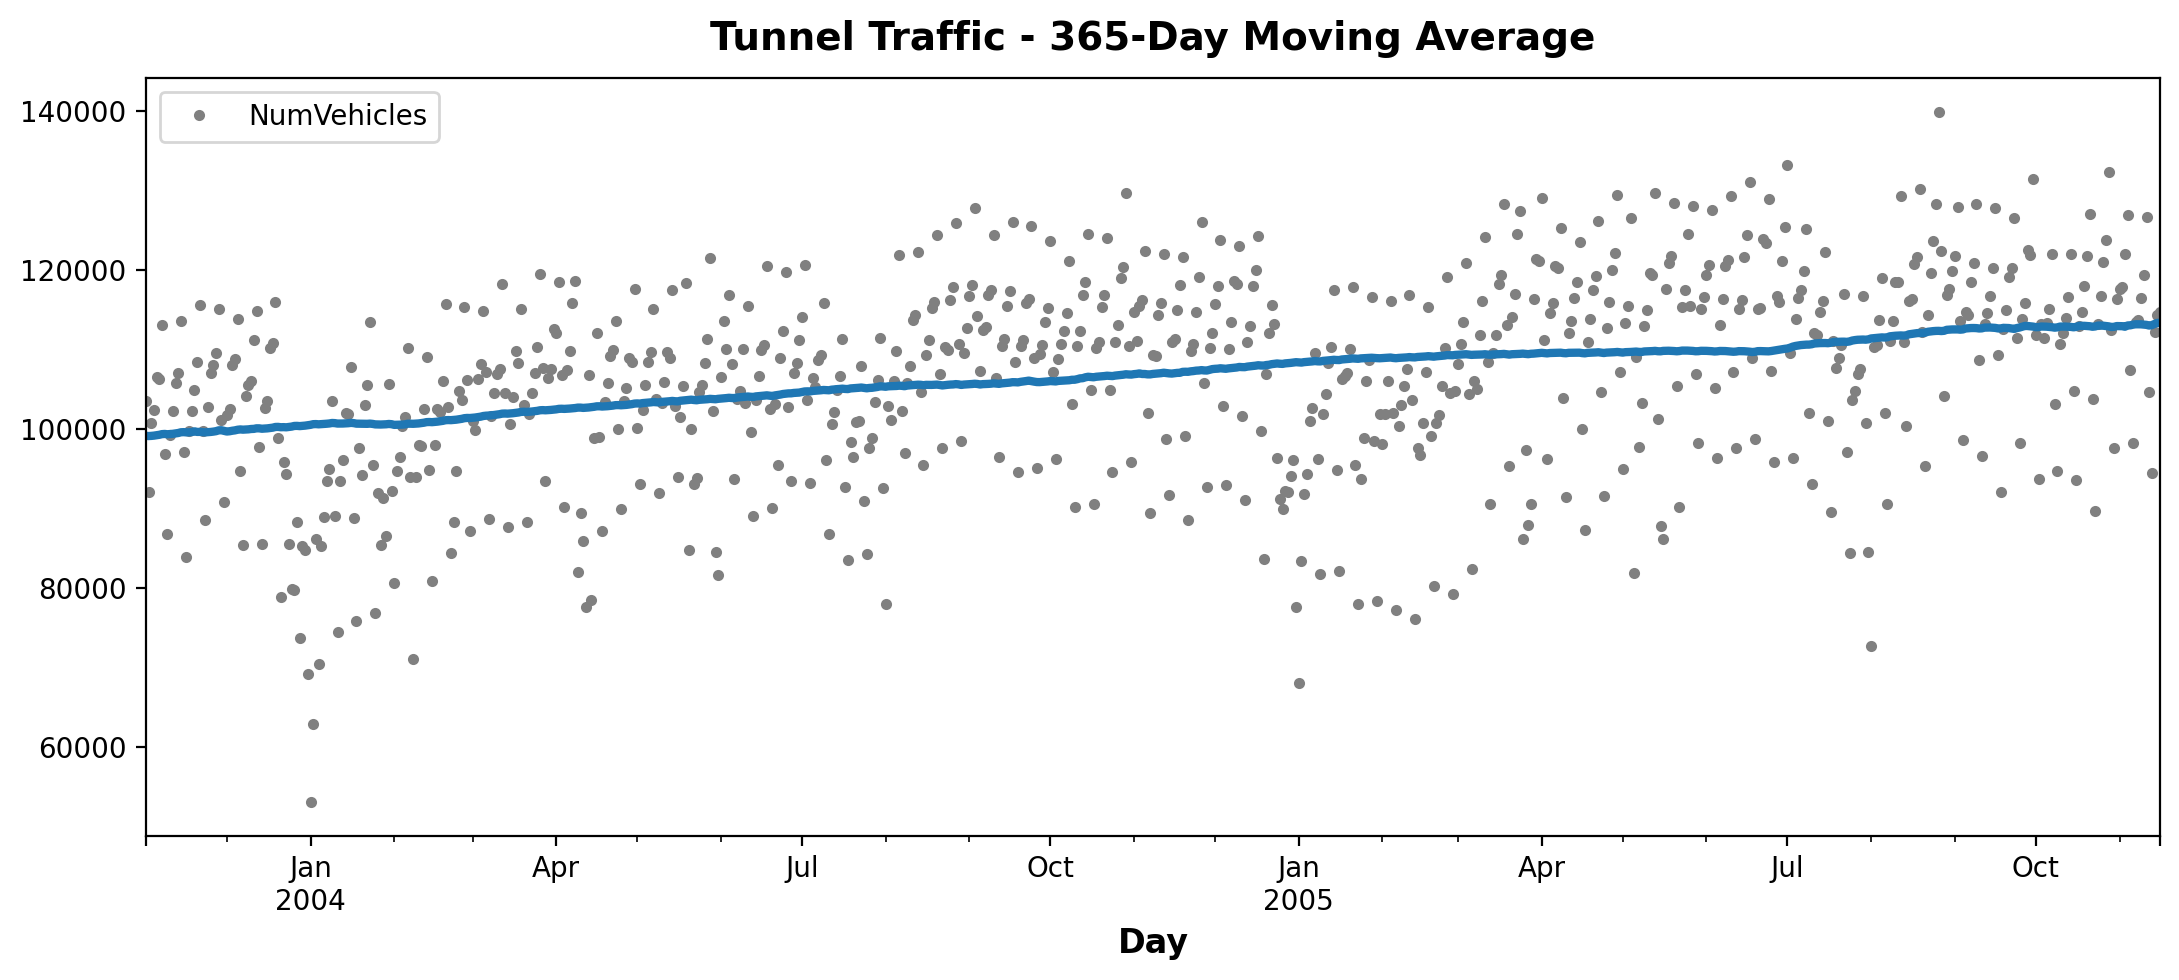

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("Modelos/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


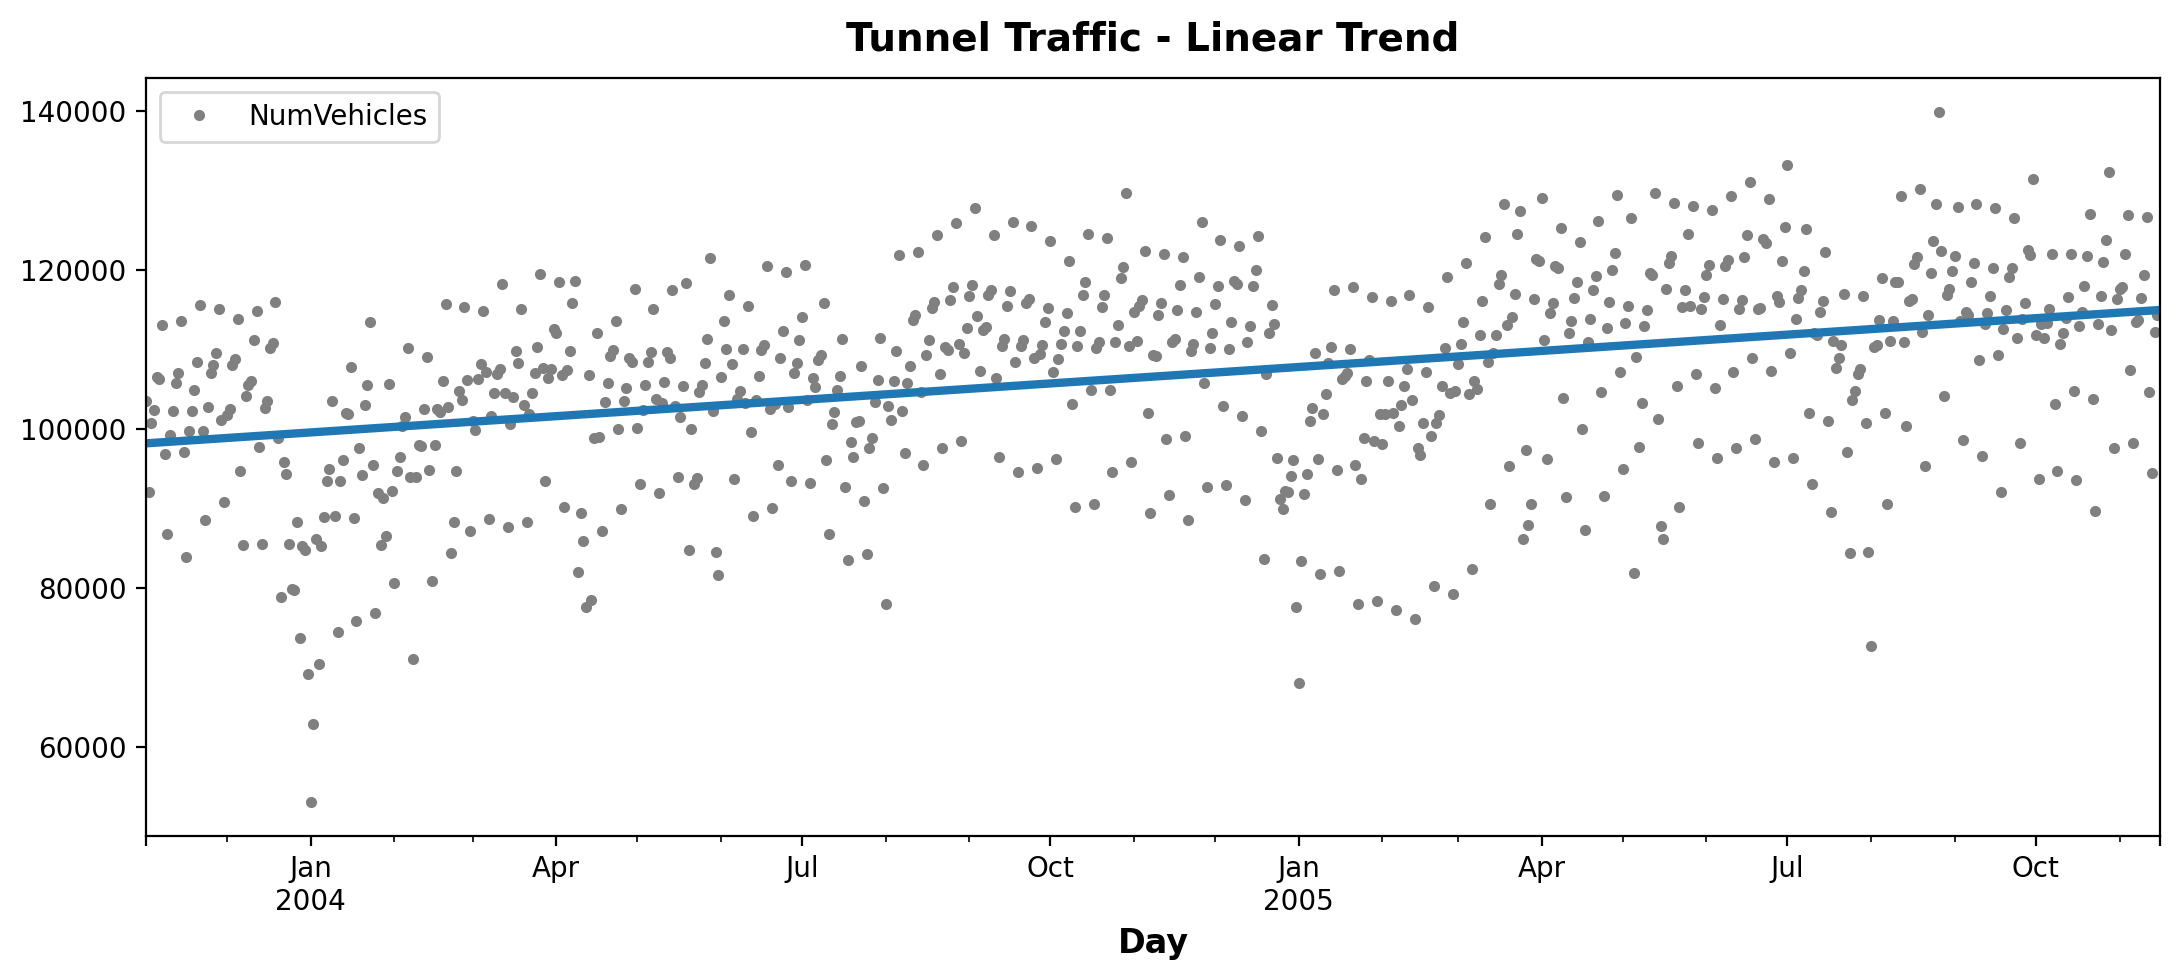

In [5]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

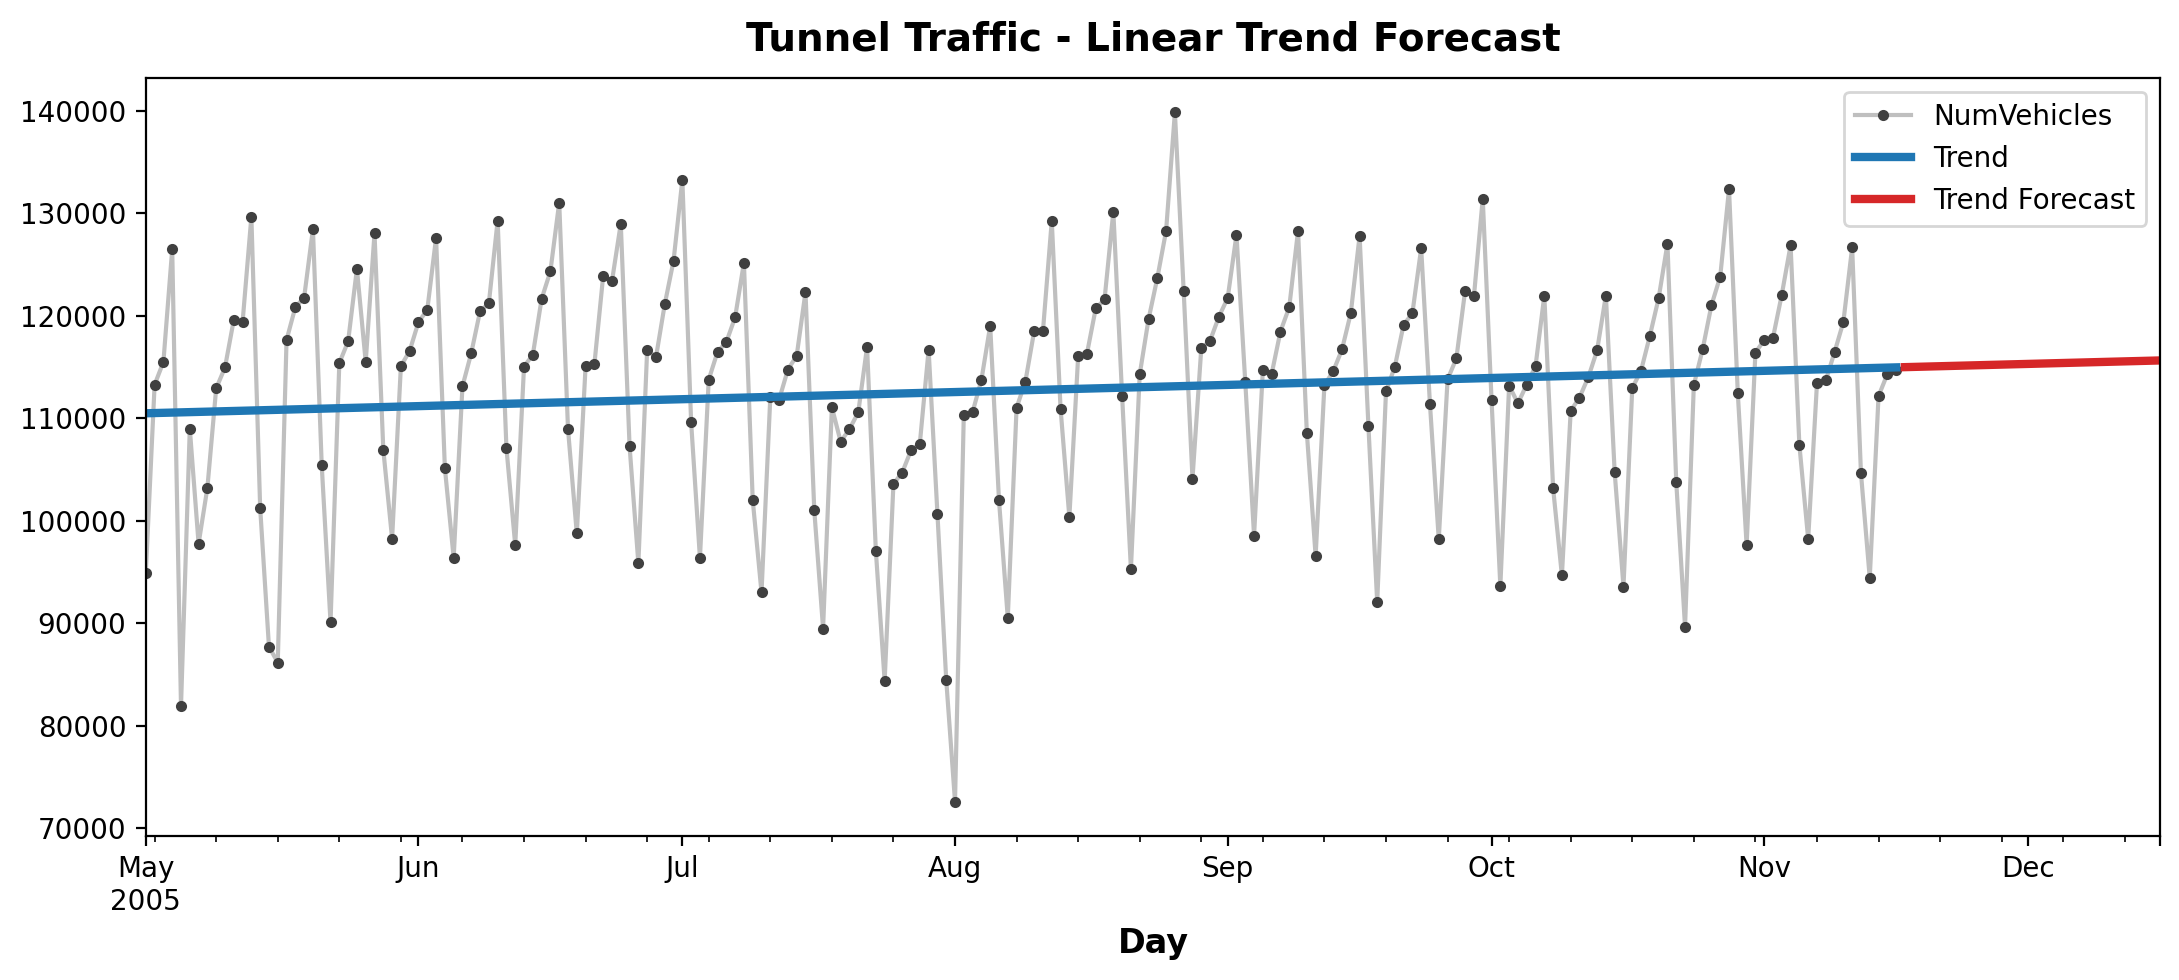

In [6]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()